<div style="text-align: center; display:block">
    <div style="display: inline-block">
        <h1  style="text-align: center">Prediction Model Binary Text Classification</h1>
        <div style="width:80%; text-align: center"><i>Author:</i> <strong>Soham Mullick</strong> </div>
    </div>
</div>

The purpose of this module is to compile and train a deep neural network on the training examples(generated from previous module) to make predictions on the avoidability of an RMA request


<b>Input</b>- Processed and Bigrammed Labelled dataset

<b>Output</b> - Trained Model Structure,Trained Model Weights,Trained Tokenizer Object

#### Load Required Libraries

In [1]:
# Core Modules
import os
import numpy as np
import pandas as pd
import configparser
import logging
import time
from numpy import random
import logging

# Text to Sequence Modules
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import utils as np_utils

# Word2Vec Library
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec

#Tensorflow
import tensorflow as tf

#Scikit Learn Packages for Model Evaluation
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#Keras Modules for Deep Net Architecture
from keras.models import Sequential, Model
from keras.layers import (Activation, Dense, Dropout, Embedding, 
                          Flatten, Input, 
                          Conv1D, MaxPooling1D,LSTM)
from keras.layers.merge import Concatenate
from keras import metrics
from keras import callbacks
from keras.models import Sequential, Model
from keras.layers import (Activation, Dense, Dropout, Embedding, PReLU,
                          Flatten, Input, BatchNormalization,
                          Conv1D, MaxPooling1D,LSTM)
from keras.layers.merge import Concatenate
from keras import metrics
from keras import callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import TensorBoard

# Modules used for Visualizations
import matplotlib.pyplot as plt
from ggplot import *
import pickle

Using TensorFlow backend.
/usr/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Defining Input Sources and Column name Variables

In [3]:
clean_file = "./Data/Final_ADS_cleaned_bigrammed.csv"  #Input File Name
word2vec_file = "./w2v_embedding"                      #Trained Word Embedding
datacol_ug = "processed_prob_desc"                     #Column Name To be used for unigram analysis
datacol_bg = "bigrammed_processed_prob_desc"           #Column Name To be used for Bigram analysis
flag = "rma_flag"                                      #Column Name for the Label

#### Model Control Box

In [7]:
##Prepare ADS by tweaking the rma ratio
use_bg=True
rma_ratio=0.1                   # Value must be less than 1(rma_ratio=No. of RMA cases/ No. of NO RMA cases to be kept in ADS)

## text2sequence Controls
MAX_NB_WORDS=None                   #Max number of words in current word embedding
MAX_SEQUENCE_LENGTH=100             # Max Sequence Length

## Deep Layer Controls
embedding_size=300                  # Must be same as the word embedding vector length
loss='binary_crossentropy'          #Loss Funtion - to bes used for calculating and minimising loss throughout the training   
optimizer='sgd'                     #Optimiser - Algorithm to be used for minimising the loss function
model_epoch=80                      #No. of epochs to run
model_batch=128                     #Batch Size - no. of examples to be considered for a single forward pass of the network

### Create Logging File

In [ ]:
# Create logger file
logging.basicConfig(filename="Prediction_Model_Training_{}.log".format(time.strftime('%b-%d-%Y_%H%M',time.localtime())),level=logging.DEBUG)

### Defining the functions

In [4]:
def getFile(fileName):
    try :
        raw_data=pd.read_csv(fileName,encoding='latin-1') #Change the Filename in config to use different Dataset
    except FileNotFoundError:
        print('\n File name not Correct. Please try again')
    return raw_data

#### Converting Text data to Suitable Sequence be used for Deep Layers (Converting to Sequence of tensors)

In [13]:
#To Convert a list into list of strings
def stringConverter(list1):
    list2=[str(i) for i in list1]
    return list2

#To Convert text to sequence to be used for creating training and test datasets 
def pre_process(df,bigram=True):
    label_list=df[flag]
    if bigram:
        s=df[datacol_bg]
    else:
        s=df[datacol_ug]
    text_list=stringConverter(s)                                                               #Creates List of Strings
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\]^`{|}~\t\n') #Initialise Tokenizer Object
    tokenizer.fit_on_texts(text_list)                                        #Train tokenizer object on the List of Strings
    #Saves the Learned tokenizer object to be used in live prediction phase
    with open('tokenizer_object.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    sequences = tokenizer.texts_to_sequences(text_list)                                      #Convert from text to sequence 
    word_index = tokenizer.word_index 
    logging.debug('Found %s unique tokens.' % len(word_index)) 
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)                     #Pad converted sequence to fixed length
    labels = np_utils.to_categorical(np.asarray(label_list))   #Converting to categorical to be used as labels for training
    logging.debug('Shape of data tensor:', data.shape)
    logging.debug('Shape of label tensor:', labels.shape)
    return data,labels,label_list,tokenizer

#### Load Raw Data

In [5]:
raw_data=getFile(clean_file)
logging.debug("In Raw dataset the number of #RMA's are: "+str(len(raw_data[raw_data[flag]==0]))+" and the number of #No RMA's are: "+str(len(raw_data[raw_data[flag]==1])))

#### Create ADS to be used for training and testing of Model

In [8]:
ADS = raw_data

### Sampling Techniques to sub-sample/oversample the ADS to generate Training and Test Datasets

In [9]:
# FOR UNDERSAMPLING
df1=ADS[ADS[flag]==0]
no_rma_case=min(int(1/rma_ratio)*len(df1),len(ADS[ADS[flag]==1]))
df2=ADS[ADS[flag]==1]
df3=df2.sample(no_rma_case)
frames=[df1,df3]
ADS=pd.concat(frames)
ADS = shuffle(ADS)

In [10]:
# FOR OVERSAMPLING with Replication
from sklearn.utils import resample
df1=ADS[ADS[flag]==0]
df2=ADS[ADS[flag]==1]
# Upsample minority class
df_upsampled = resample(df1,replace=True,               # sample with replacement
                                 n_samples=len(df2),    # to match majority class
                                 random_state=123)      # reproducible results
 
# Combine majority class with upsampled minority class
ADS = shuffle(pd.concat([df_upsampled, df2]))

#### Basic Info Regarding the ADS

In [11]:
print("Number of cases in ADS: "+str(len(ADS)))#+"    Number of cases in Validation Dataset: "+str(len(val_data)))
print("In ADS the number of #RMA's are: "+str(len(ADS[ADS[flag]==0]))+" and the number of #No RMA's are: "+str((len(ADS[ADS[flag]==1]))))

Number of cases in ADS: 17520
In ADS the number of #RMA's are: 3522 and the number of #No RMA's are: 13998


#### Pre-Process Data for Model Training

In [14]:
data,labels,ADS_label_list,tokenizer=pre_process(ADS,use_bg)

#### Generate Train and Test Data

In [16]:
train_data,test_data=train_test_split(ADS, test_size=0.2,stratify=ADS[flag],random_state=50)

#### Save The Training and Test Datasets

In [17]:
test_data.to_csv("cat2k_retraining_may9_iter2_test.csv")

In [18]:
train_data.to_csv("cat2k_retraining_may9_iter2_train.csv")

#### Generate Feature Vector (Input) and Labels (Output) for model training

In [19]:
x_train, x_test, y_train,y_test,train_label,test_label = train_test_split(data,labels,ADS_label_list, test_size=0.2,stratify=ADS_label_list,random_state=50)

### Load Pre-Trained Word2Vec

In [12]:
# Loading Pre-trained word2vec model to be used as Embedding layer in Deep Model
embedding = Word2Vec.load(word2vec_file)

#### Extracting the embedded word vectors


In [15]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, embedding_size))
for word, i in tokenizer.word_index.items():                            
    try:
        embedding_vector = embedding.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except:
        continue

### Build Prediction model

#### Creating Layers

In [22]:
# Both the Layers and their hyper-parameters are customisable
deep_model=Sequential()
deep_model.add(Embedding(len(tokenizer.word_index) + 1,
                            embedding_size,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))

deep_model.add(Dense(512,kernel_initializer='truncated_normal'))
deep_model.add(BatchNormalization())
deep_model.add(Activation('relu'))
deep_model.add(Dropout(0.25))

deep_model.add(Dense(256,kernel_initializer='truncated_normal'))
deep_model.add(BatchNormalization())
deep_model.add(Activation('relu'))
deep_model.add(Dropout(0.25))

deep_model.add(Dense(128,kernel_initializer='truncated_normal'))
deep_model.add(BatchNormalization())
deep_model.add(Activation('relu'))
deep_model.add(Dropout(0.25))

deep_model.add(Dense(64,kernel_initializer='truncated_normal'))
deep_model.add(BatchNormalization())
deep_model.add(Activation('relu'))
deep_model.add(Dropout(0.25))

deep_model.add(Dense(32,kernel_initializer='truncated_normal'))
deep_model.add(BatchNormalization())
deep_model.add(Activation('relu'))
deep_model.add(Dropout(0.25))

deep_model.add(Flatten())

deep_model.add(Dense(1600,kernel_initializer='truncated_normal'))
deep_model.add(BatchNormalization())
deep_model.add(Activation('relu'))

deep_model.add(Dense(800,kernel_initializer='truncated_normal'))
deep_model.add(BatchNormalization())
deep_model.add(Activation('relu'))

deep_model.add(Dense(200,kernel_initializer='truncated_normal'))
deep_model.add(BatchNormalization())
deep_model.add(Activation('relu'))

deep_model.add(Dense(20,kernel_initializer='truncated_normal'))
deep_model.add(BatchNormalization())
deep_model.add(Activation('relu'))


deep_model.add(Dense(2,activation='softmax'))

#### Summary of the Layers we have

In [26]:
deep_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          3516900   
_________________________________________________________________
dense_1 (Dense)              (None, 100, 512)          154112    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 512)          2048      
_________________________________________________________________
activation_1 (Activation)    (None, 100, 512)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 100, 256)          131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 256)          1024      
__________

#### Saving the Model architecture (JSON format)

In [27]:
serialize model to JSON
model_json = deep_model.to_json()
with open("deep_model_rma_classification.json", "w") as json_file:
    json_file.write(model_json)

#### Creating Class Weights for Class Sensitive Cost Function

In [23]:
class_weight = class_weight.compute_class_weight('balanced', np.unique(train_label), train_label)
class_weight_dict = dict(enumerate(class_weight))
print(class_weight_dict)

{0: 2.4868701206529455, 1: 0.62582604036435074}


#### Defining the Loss function and the optimiser to be used for training

In [24]:
deep_model.compile(loss=loss, optimizer=optimizer,metrics=[metrics.mse, metrics.binary_accuracy])

#### Defining path to save model weights

In [25]:
# Define checkpoint
output_dir = 'output_Logs/iter2'
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

#### Fit the model to training data and get accuracy on test data

In [28]:
start = time.time()
history=deep_model.fit(x_train, y_train, validation_data=(x_test, y_test),
                       epochs=model_epoch, 
                       batch_size=model_batch,
                       class_weight=class_weight_dict,
                       callbacks=[modelcheckpoint]
                      )
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Train on 14016 samples, validate on 3504 samples
Epoch 1/80
14016/14016 [==============================] - 51s 4ms/step - loss: 0.4945 - mean_squared_error: 0.1716 - binary_accuracy: 0.7451 - val_loss: 0.8438 - val_mean_squared_error: 0.3141 - val_binary_accuracy: 0.4304
Epoch 4/80
14016/14016 [==============================] - 51s 4ms/step - loss: 0.4526 - mean_squared_error: 0.1505 - binary_accuracy: 0.7918 - val_loss: 0.5438 - val_mean_squared_error: 0.1788 - val_binary_accuracy: 0.7483
Epoch 5/80
14016/14016 [==============================] - 52s 4ms/step - loss: 0.4278 - mean_squared_error: 0.1381 - binary_accuracy: 0.8084 - val_loss: 0.4652 - val_mean_squared_error: 0.1471 - val_binary_accuracy: 0.7939
Epoch 6/80
14016/14016 [==============================] - 52s 4ms/step - loss: 0.4099 - mean_squared_error: 0.1319 - binary_accuracy: 0.8186 - val_loss: 0.4527 - val_mean_squared_error: 0.1408 - val_binary_accuracy: 0.8051
Epoch 7/80
14016/14016 [==============================] - 5

Epoch 75/80
14016/14016 [==============================] - 51s 4ms/step - loss: 0.2657 - mean_squared_error: 0.0841 - binary_accuracy: 0.8866 - val_loss: 0.3911 - val_mean_squared_error: 0.1208 - val_binary_accuracy: 0.8408
Epoch 76/80
14016/14016 [==============================] - 51s 4ms/step - loss: 0.2653 - mean_squared_error: 0.0853 - binary_accuracy: 0.8841 - val_loss: 0.3610 - val_mean_squared_error: 0.1105 - val_binary_accuracy: 0.8545
Epoch 77/80
14016/14016 [==============================] - 51s 4ms/step - loss: 0.2638 - mean_squared_error: 0.0842 - binary_accuracy: 0.8842 - val_loss: 0.3749 - val_mean_squared_error: 0.1155 - val_binary_accuracy: 0.8467
Epoch 78/80
14016/14016 [==============================] - 51s 4ms/step - loss: 0.2635 - mean_squared_error: 0.0828 - binary_accuracy: 0.8877 - val_loss: 0.3762 - val_mean_squared_error: 0.1157 - val_binary_accuracy: 0.8473
Epoch 79/80
14016/14016 [==============================] - 51s 4ms/step - loss: 0.2607 - mean_squared_er

#### Changing the trained model weights between different epoch

In [44]:
deep_model.load_weights(output_dir+"/weights.35.hdf5")   #To choose a particular epoch weights to initialise model 

#### Look at the Probability Distribution of the test data prediction

In [45]:
y_hat = deep_model.predict_proba(x_test)

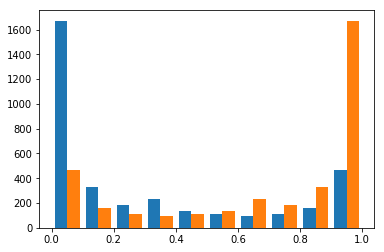

In [48]:
plt.hist(y_hat)
plt.show()

### Evaluate Model Training

#### Training Plots of different metrics on train and test data

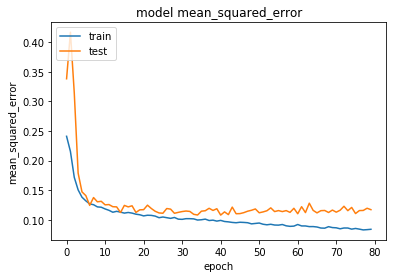

In [35]:
# summarize history for MSE
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

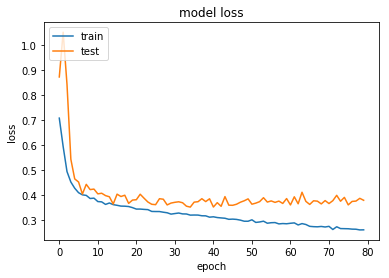

In [36]:
# summarize history for Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

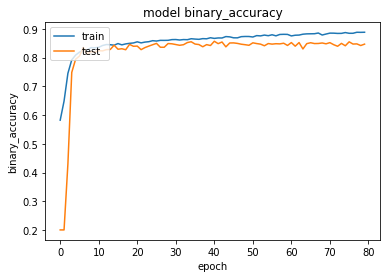

In [37]:
# summarize history for Categorical Accuracy (Binary)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model binary_accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluate Model Performance

#### Defining the Functions

In [50]:
# To Visualise the Confusion Matrix
def show_confusion_matrix(C,class_labels=['RMA','NO RMA']): 
        assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
        # true negative, false positive, etc...
        tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];
        NP = fn+tp # Num positive examples
        NN = tn+fp # Num negative examples
        N  = NP+NN
        fig = plt.figure(figsize=(8,8))
        ax  = fig.add_subplot(111)
        ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

        # Draw the grid boxes
        ax.set_xlim(-0.5,2.5)
        ax.set_ylim(2.5,-0.5)
        ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
        ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
        ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
        ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

        # Set xlabels
        ax.set_xlabel('Predicted Label', fontsize=16)
        ax.set_xticks([0,1,2])
        ax.set_xticklabels(class_labels + [''])
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
        # These coordinate might require some tinkering. Ditto for y, below.
        ax.xaxis.set_label_coords(0.34,1.06)

        # Set ylabels
        ax.set_ylabel('True Label', fontsize=16, rotation=90)
        ax.set_yticklabels(class_labels + [''],rotation=90)
        ax.set_yticks([0,1,2])
        ax.yaxis.set_label_coords(-0.09,0.65)

        # Fill in initial metrics: tp, tn, etc...
        ax.text(0,0,'True Neg: %d\n(Num Neg: %d)'%(tn,NN),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
        ax.text(0,1,'False Neg: %d'%fn,va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
        ax.text(1,0,'False Pos: %d'%fp,va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
        ax.text(1,1,'True Pos: %d\n(Num Pos: %d)'%(tp,NP),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
        # Fill in secondary metrics: accuracy, true pos rate, etc...
        ax.text(2,0,'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
        ax.text(2,1,'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
        ax.text(2,2,'Accuracy: %.2f'%((tp+tn+0.)/N),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
        ax.text(0,2,'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
        ax.text(1,2,'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'))
        plt.tight_layout()
        plt.show()

#To Find the optimal cutoff from P
def Find_Optimal_Cutoff(df):
    target=list(df['Actual'])
    predicted=list(df['Probability'])
    #print(target,predicted)
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 


#### Getting Predictions on Test Data

In [51]:
# Predict Classes
ytest_pred=deep_model.predict_classes(x_test)

In [52]:
# Predict Probabilities
ytest_proba=deep_model.predict(x_test)

#### Plot the ROC curve and get the AUC

0.917736657873


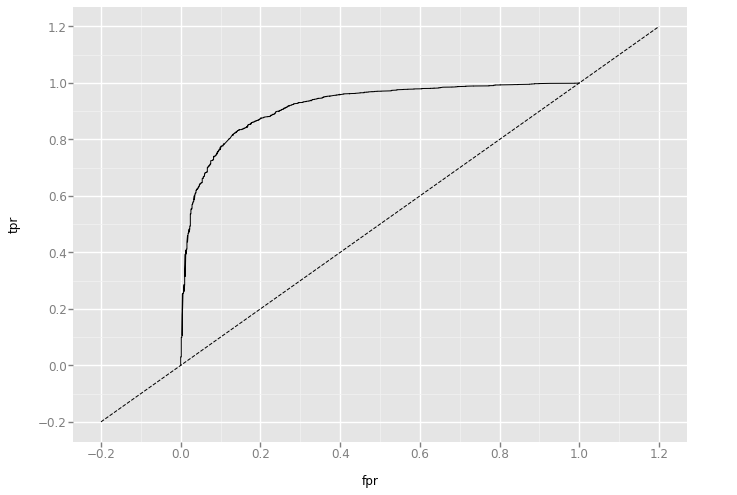

<ggplot: (-9223363282484408860)>

In [54]:
fpr, tpr, _ = roc_curve(check['Actual'], check['Probability'])
print(roc_auc_score(check['Actual'], check['Probability']))
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

#### Test Data Confusion Matrix (Before Threshold)

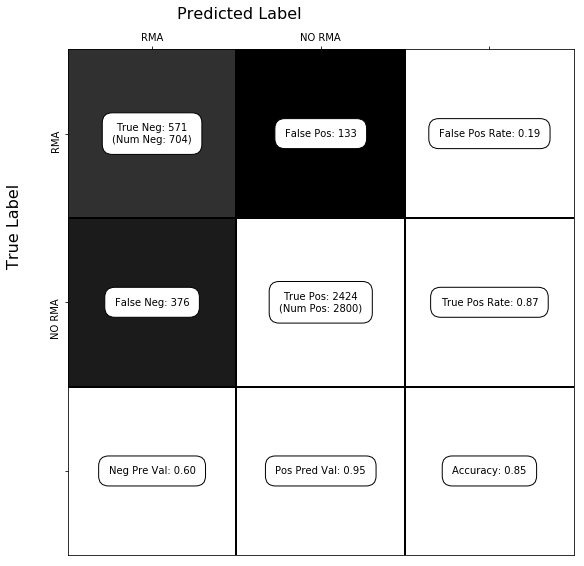

In [55]:
C1=confusion_matrix(test_label,ytest_pred)
show_confusion_matrix(C1)